In [12]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasRegressor

In [3]:
df = pd.read_csv('processedcsv/combinedstats.csv')
df.dropna(inplace=True)
X = df.drop(['player_id', 'firstName', 'lastName', 'season', 'salary', 'avgTimeOnIce', 'avgPowerPlayTimeOnIce', 'avgShortHandedTimeOnIce', 'birthDate'], axis=1)
y = df.filter(['salary'])

In [4]:
onehot = OneHotEncoder()
X_pos = onehot.fit_transform(X[['primaryPosition']])
X_hand = onehot.fit_transform(X[['shootsCatches']])
df1 = pd.DataFrame.sparse.from_spmatrix(X_pos)
df2 = pd.DataFrame.sparse.from_spmatrix(X_hand)
df1.rename(columns={0: 'isC', 1: 'isD', 2: 'isLW', 3: 'isRW'}, inplace=True)
df2.rename(columns={0: 'shootsL', 1: 'shootsR'}, inplace=True)
df3 = pd.concat([df1, df2], axis=1)
X_new = pd.concat([df3.reset_index(), X.drop(['primaryPosition', 'shootsCatches'], axis=1).reset_index()], axis=1)
X_normalized=(X_new-X_new.min())/(X_new.max()-X_new.min())

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.30, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=5)

In [13]:
clf = Lasso()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
results = y_test.copy()
results['pred'] = y_pred.tolist()
results.head()

salary          pred
4829  6375000  4.733070e+06
4403  5000000  2.521960e+06
4041   650000  2.805224e+06
3665  1450000  1.064701e+06
3844  1975000  2.342338e+06

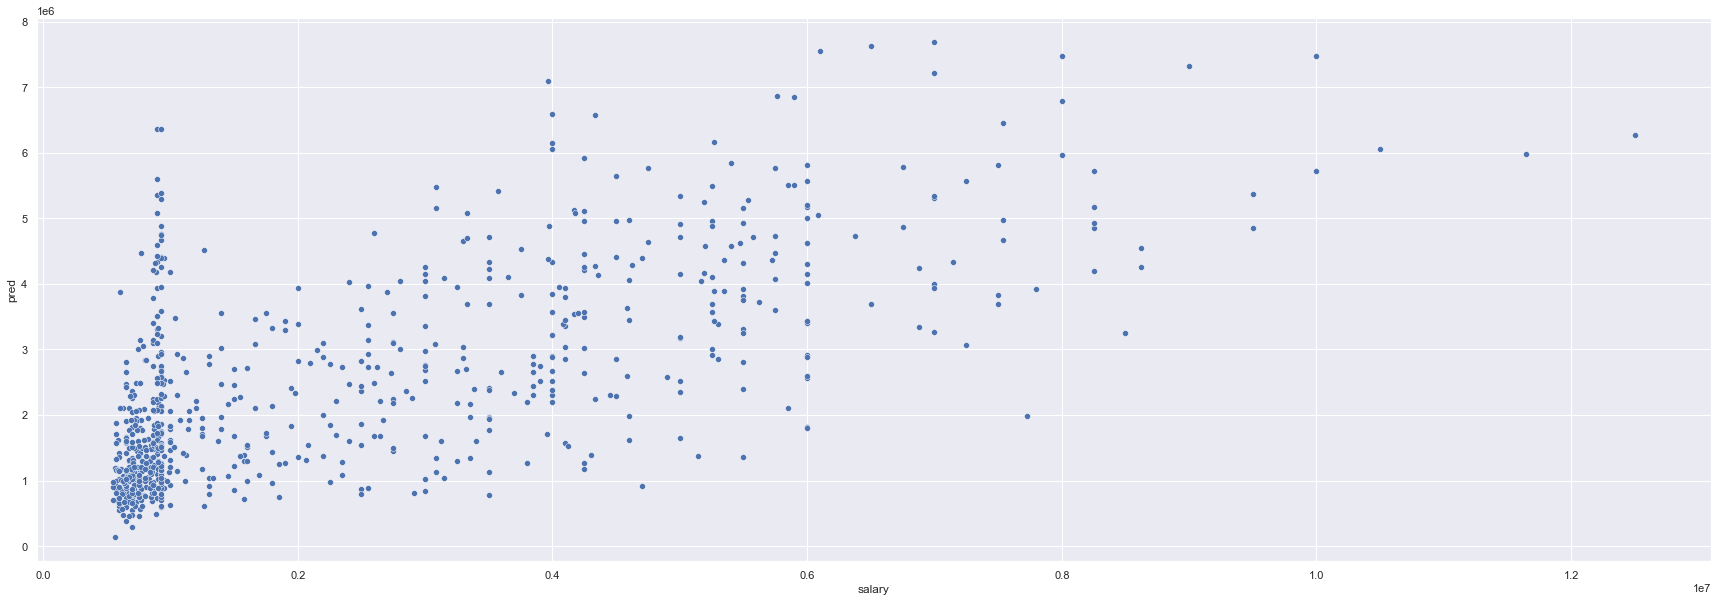

In [32]:
sns.set(rc = {'figure.figsize':(30,10)})
sns.scatterplot(x='salary', y='pred', data=results);

In [ ]:
selector = RFE(clf, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

In [39]:
selector.get_support()

array([False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False,  True, False, False,  True,
        True,  True,  True, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False,  True])

In [38]:
print(X_train.shape)
list(X_train.columns)

(3634, 35)


['index',
 'isC',
 'isD',
 'isLW',
 'isRW',
 'shootsL',
 'shootsR',
 'index',
 'gamesPlayed',
 'goals',
 'assists',
 'points',
 'pointsPerGame',
 'plusMinus',
 'shots',
 'shootingPercentage',
 'penaltyMinutes',
 'timeOnIce',
 'faceOffWins',
 'faceOffLosses',
 'faceOffTaken',
 'faceOffPercentage',
 'hits',
 'blocks',
 'takeaways',
 'giveaways',
 'turnoverDifferential',
 'powerPlayGoals',
 'powerPlayAssists',
 'powerPlayPoints',
 'powerPlayTimeOnIce',
 'shortHandedGoals',
 'shortHandedAssists',
 'shortHandedPoints',
 'shortHandedTimeOnIce']

In [15]:
def get_model():
    model = Sequential()
    model.add(Dense(35, input_dim= 35, activation='relu'))
    model.add(Dense(22, kernel_initializer='normal'))
    model.add(Dense(11, kernel_initializer='normal'))
    model.add(Dense(6, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model

model = get_model()
model.fit(X_train, y_train, epochs = 200, batch_size = 5, verbose=False)
print('Finished training 200 epochs')
y_pred = model.predict(X_test)

Finished training 200 epochs


salary          pred
4829  6375000   [4785462.5]
4403  5000000   [2947420.5]
4041   650000  [3016706.75]
3665  1450000   [1256310.0]
3844  1975000  [2423508.25]

In [25]:
df.iloc[4041] #3016706.75

player_id                     8467496
firstName                      Andrei
lastName                       Markov
birthDate                  1978-12-20
primaryPosition                     D
shootsCatches                       L
season                        2014-15
gamesPlayed                        81
goals                              10
assists                            40
points                             50
pointsPerGame                    0.62
plusMinus                          22
shots                             135
shootingPercentage               7.41
penaltyMinutes                     38
timeOnIce                    121064.0
avgTimeOnIce                    24:54
faceOffWins                         0
faceOffLosses                       0
faceOffTaken                        0
faceOffPercentage                 0.0
hits                               53
blocks                            173
takeaways                          46
giveaways                          79
turnoverDiff